In [1]:
#https://keras.io/examples/rl/deep_q_network_breakout/
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten, ZeroPadding2D, UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

Using TensorFlow backend.


In [2]:
import pygame, sys, time, random
import cv2
import numpy as np
import base64
import os.path
import pandas as pd 
import re
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import savgol_filter
import math

pygame 2.0.0.dev6 (SDL 2.0.10, python 3.7.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
tf.enable_eager_execution() 

In [4]:
dim = (50,50) 
pathname = r"C:\Users\Flo\Studium\Sem5\Bilder"
datadirname = ""
testdirname = "test"
validdirname = "valid"
modeldirname = "model"
datacsvname = "data.csv"
modeljsonname="model.json"
modelweightname="model-regr.h5"




actionstonum = {"RIGHT": 0,
           "LEFT": 1,
           "UP" : 2,
           "DOWN" : 3,
          }
numtoactions = {0: "RIGHT",
           1: "LEFT",
           2: "UP",
           3: "DOWN",
          }

In [5]:
def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(dim[0], dim[1], 3,))

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(4, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

In [6]:
#model = create_q_model()
#model_json = model.to_json()
#with open(os.path.join(pathname, modeldirname,modeljsonname), "w") as json_file:
#    json_file.write(model_json)
#model.save_weights(os.path.join(pathname, modeldirname,modelweightname))

In [7]:
manual = False

In [8]:
class Game:


    def __init__(self, lr=1e-3, checkpointparname=modelweightname):
        
        self.speed = 80

        self.frame_size_x = 200
        self.frame_size_y = 200

        self.black = pygame.Color(0, 0, 0)
        self.white = pygame.Color(255, 255, 255)
        self.green = pygame.Color(0, 255, 0)
        self.mag = pygame.Color(255, 0, 255)
        
        self.imgresh1 = None
        self.imgresh2 = None
        
        self.reward = 0
        self.MAXREWARD = 1.0
        self.PENALTY = -1.0
        self.MOVEPENALTY = 0.0
        
        self.BATCHSIZE = 19
        self.DISCOUNT = 0.99
        self.ALPHA = 0.3
        
        if manual == True:
            self.EPSILON = 0.999
        else:
            self.EPSILON = 0.3
        
        self.REPLAYSIZE = 40_000
        self.overall_score = 0
        self.overall_numbatches = 0
        self.overall_accumulatedstates = np.array([0.0,0.0,0.0,0.0])
        
        
        self.path = os.path.join(pathname, datadirname)
        self.modelpath =  os.path.join(pathname, modeldirname)
        
        self.filename = "data.csv"
        
        self.model = create_q_model()
        self.model_target = create_q_model()

        self.learningrate = lr
        self.optimizer = keras.optimizers.Adam(learning_rate=self.learningrate, clipnorm=1.0)
        self.loss_function = keras.losses.Huber()

        self.checkpointname = os.path.join(pathname, modeldirname,checkpointparname)
        print(f"loading checkpoint: {self.checkpointname}")
        self.model_target.load_weights(self.checkpointname)
        
        self.overall_scores=[]
        self.checkpoint_counter=0
        
        self.shufflelist = []
        self.debugcounter = 0
        
    def initialize(self, i, j):

        status = pygame.init()

        if status[1] > 0:
            print(f'Number of Errors: {status[1]} ...')
            sys.exit(-1)


        # Initialise game window
        pygame.display.set_caption(f"{i}-{j}")
        self.game_window = pygame.display.set_mode((self.frame_size_x, self.frame_size_y)) 

        
        self.controller = pygame.time.Clock()
   
        posx = (random.randint(40,160)//10)*10
        posy = (random.randint(40,160)//10)*10
           
        self.snake_pos = [posx, posy]
        self.snake_body = [[posx, posy], [posx-10, posy], [posx-(2*10), posy]]

        self.food_pos = [random.randrange(1, (self.frame_size_x//10)) * 10, random.randrange(1, (self.frame_size_y//10)) * 10]
        self.food_spawn = True

        self.direction = 'RIGHT'
        self.changeto = self.direction

        self.score = 0
        self.numbatches = 0

        self.event_happened = False
        
        self.model.load_weights(self.checkpointname)

            
    def run(self, i_index):
        
        i = i_index + self.get_maxi() + 1
        j = 0

        while True:
            
            img1 = np.frombuffer(pygame.image.tostring(self.game_window, "RGB"), dtype=np.uint8)
            self.imgresh1 = np.reshape(img1,(self.frame_size_x,self.frame_size_y, 3))
            self.imgresh1 = cv2.resize(self.imgresh1, dim, interpolation = cv2.INTER_NEAREST )
            #current_state = [self.imgresh1]
            #astate = self.model.predict(np.array(current_state)/255.0, batch_size=1, verbose=0)[0]  
            #theaction = np.argmax(astate)
            
            current_state = np.array(self.imgresh1, dtype=np.float32)/255.0
            state_tensor = tf.convert_to_tensor(current_state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = self.model(state_tensor, training=False)
            theaction = tf.argmax(action_probs[0]).numpy()
            
            assert theaction < 5 and theaction >= 0
            
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    return
                # Whenever a key is pressed down
                elif event.type == pygame.KEYDOWN:

                    if event.key == pygame.K_UP or event.key == ord('w'):
                        self.changeto = 'UP'
                    if event.key == pygame.K_DOWN or event.key == ord('s'):
                        self.changeto = 'DOWN'
                    if event.key == pygame.K_LEFT or event.key == ord('a'):
                        self.changeto = 'LEFT'
                    if event.key == pygame.K_RIGHT or event.key == ord('d'):
                        self.changeto = 'RIGHT'
                    
                    # Esc -> Create event to quit the game
                    if event.key == pygame.K_ESCAPE:
                        pygame.event.post(pygame.event.Event(pygame.QUIT))


            if np.random.random() > self.EPSILON:
                self.changeto = numtoactions[theaction]
            else:
                if manual != True:
                    #self.changeto = numtoactions[np.random.randint(0, len(actionstonum))]
                    self.changeto = self.get_direction();
                assert actionstonum[self.changeto] >= 0
                assert actionstonum[self.changeto] < 5
                    
            if self.changeto == 'UP' and self.direction != 'DOWN':
                self.direction = 'UP'
            if self.changeto == 'DOWN' and self.direction != 'UP':
                self.direction = 'DOWN'
            if self.changeto == 'LEFT' and self.direction != 'RIGHT':
                self.direction = 'LEFT'
            if self.changeto == 'RIGHT' and self.direction != 'LEFT':
                self.direction = 'RIGHT'

            if self.direction == 'UP':
                self.snake_pos[1] -= 10
            if self.direction == 'DOWN':
                self.snake_pos[1] += 10
            if self.direction == 'LEFT':
                self.snake_pos[0] -= 10
            if self.direction == 'RIGHT':
                self.snake_pos[0] += 10

            self.snake_body.insert(0, list(self.snake_pos))
            if self.snake_pos[0] == self.food_pos[0] and self.snake_pos[1] == self.food_pos[1]:
                #self.snake_body.pop() # to be deleted
                self.score += 1
                self.reward = self.MAXREWARD
                self.food_spawn = False
            else:
                self.snake_body.pop()
                self.reward = self.MOVEPENALTY
                #self.reward = self.get_continuous_move_penalty()
                

            if not self.food_spawn:
                self.food_pos = [random.randrange(1, (self.frame_size_x//10)) * 10, random.randrange(1, (self.frame_size_y//10)) * 10]
            self.food_spawn = True

            self.game_window.fill(self.black)
            n = 0
            for pos in self.snake_body:

                if n == 0:
                    pygame.draw.rect(self.game_window, self.mag, pygame.Rect(pos[0], pos[1], 10, 10))
                else:
                    pygame.draw.rect(self.game_window, self.green, pygame.Rect(pos[0], pos[1], 10, 10))
                n=+1
                

            pygame.draw.rect(self.game_window, self.white, pygame.Rect(self.food_pos[0], self.food_pos[1], 10, 10))

            if self.snake_pos[0] < 0 or self.snake_pos[0] > self.frame_size_x-10:
                self.game_over(i,j)
                return
            if self.snake_pos[1] < 0 or self.snake_pos[1] > self.frame_size_y-10:
                self.game_over(i,j)
                return

            for block in self.snake_body[1:]:
                if self.snake_pos[0] == block[0] and self.snake_pos[1] == block[1]:
                    self.game_over(i,j)
                    return

            pygame.display.update()

            img2 = np.frombuffer(pygame.image.tostring(self.game_window, "RGB"), dtype=np.uint8)
            self.imgresh2 = np.reshape(img2,(self.frame_size_x,self.frame_size_y, 3))
            self.imgresh2 = cv2.resize(self.imgresh2, dim, interpolation = cv2.INTER_NEAREST )
            
            self.controller.tick(self.speed)

            if j > 0:
                if self.reward == self.MAXREWARD:
                    self.train(i,j, False)
                elif j%4 == 0:
                    self.train(i,j, False)
      
            j += 1
            


            
    def game_over(self,i,j):
        self.reward = self.PENALTY

        img2 = np.frombuffer(pygame.image.tostring(self.game_window, "RGB"), dtype=np.uint8)
        self.imgresh2 = np.reshape(img2,(self.frame_size_x,self.frame_size_y, 3))
        self.imgresh2 = cv2.resize(self.imgresh2, dim, interpolation = cv2.INTER_NEAREST )
        
        self.train(i,j, True)
        
        self.overall_score += self.score
        
        self.game_window.fill(self.black)
        pygame.display.flip()                         
        pygame.quit()

    def get_continuous_move_penalty(self):
        
        penalty = 0
        
        assert self.snake_body[0][0] == self.snake_pos[0]
        assert self.snake_body[0][1] == self.snake_pos[1]
        
        x = self.snake_pos[0] - self.food_pos[0]
        y = self.snake_pos[1] - self.food_pos[1]
        
        distance = math.sqrt(x*x + y*y)
        
        maxdist = self.frame_size_x//4
        
        if distance > maxdist:
            penalty = self.MOVEPENALTY
        else:
            penalty = int(100*self.MOVEPENALTY*distance/maxdist)/100.0
        
        assert penalty >= self.MOVEPENALTY
        assert penalty <= 0
        
        return penalty

        

    def get_direction(self):
        assert self.snake_body[0][0] == self.snake_pos[0]
        assert self.snake_body[0][1] == self.snake_pos[1]
        
        x = self.snake_pos[0] - self.food_pos[0]
        x1 = self.snake_body[1][0] - self.food_pos[0]
        
        y = self.snake_pos[1] - self.food_pos[1]
        y1 = self.snake_body[1][1] - self.food_pos[1]
        

        
        direction = None
        direction_h = None
        direction_v = None

        if x > 0:
            direction_h = 'LEFT'
        else:
            direction_h = 'RIGHT'

        if y > 0:
            direction_v = 'UP'
        else:
            direction_v = 'DOWN'
                           

        if abs(x) > abs(y):
            direction = direction_h
            
            if y == y1 and (abs(x) > abs(x1)):
                #print(f"  hit v x: {abs(x)} x1: {abs(x1)} y: {y} y1: {y1}")
                direction = direction_v
        else:
            direction = direction_v
            if x == x1 and (abs(y) > abs(y1)):
                #print(f"  hit h x: {abs(y)} x1: {abs(y1)} y: {x} y1: {x1}")
                direction = direction_h
        
        assert direction != ''       
        
        return direction
        

    def show_score(self, choice, color, font, size):
        score_font = pygame.font.SysFont(font, size)
        score_surface = score_font.render('Score : ' + str(self.score), True, color)
        score_rect = score_surface.get_rect()
        if choice == 1:
            score_rect.midtop = (self.frame_size_x/10, 15)
        else:
            score_rect.midtop = (self.frame_size_x/2, self.frame_size_y/1.25)
        self.game_window.blit(score_surface, score_rect)
        
    def write(self, i, j): 

        cv2.imwrite(os.path.join(self.path,"current_{}_{}.png".format(i,j)), self.imgresh1)
        cv2.imwrite(os.path.join(self.path,"next_{}_{}.png".format(i,j)), self.imgresh2)

        
    def load_replay_memory(self):

        #assert os.path.isfile(os.path.join(self.path,datacsvname)) == True

        f = open(os.path.join(os.path.join(self.path,datacsvname)), "r")
        
        df = pd.read_csv(f, index_col = 0) 

        for index, row in df.iterrows():

            currentpicname = row["currentstate"]
            action = actionstonum[row["action"]]
            reward = row["reward"]
            nextpicname = row["nextstate"]
            terminated = row["terminated"]


            assert os.path.isfile(os.path.join(self.path,currentpicname)) == True
            assert (action < 5 and action >= 0)
            assert isinstance(reward,int) or isinstance(reward, float)
            assert os.path.isfile(os.path.join(self.path,nextpicname)) == True
            
            self.shufflelist.append([currentpicname,action,reward,nextpicname, terminated])
            #self.shufflelist.append([currentpicname,action,reward,nextpicname, terminated])

        random.shuffle(self.shufflelist)

        #print(f"loading: size of replay memory {len(self.shufflelist)}")
        
        f.close()
        
        return

    def save_replay_memory(self):
        
        assert os.path.isfile(os.path.join(self.path,datacsvname)) == True
        
        data = []
        
        if len(self.shufflelist) == 0:
            return
        
        if len(self.shufflelist) > self.REPLAYSIZE:
            
            self.numbatches = len(self.shufflelist) - self.REPLAYSIZE
            self.overall_numbatches += self.numbatches
            
            for i in range(len(self.shufflelist) - self.REPLAYSIZE):
                item = self.shufflelist.pop(0)
                assert os.path.isfile(os.path.join(self.path,item[0])) == True
                assert os.path.isfile(os.path.join(self.path,item[3])) == True
                os.remove(os.path.join(self.path,item[0]))
                os.remove(os.path.join(self.path,item[3]))
                
        for (cs, act, rew, fs, term, sx, sy, fx, fy) in self.shufflelist:
            
            data.append({'currentstate': cs, 'action': numtoactions[act], 'reward': rew, 'nextstate': fs, 'terminated': term, 'sxpos': sx, 'sypos': sy, 'fxpos': fx, 'fypos': fy})
            
        df = pd.DataFrame(data) 
        
        df.to_csv(os.path.join(self.path, self.filename)) 
        
        #print(f"saving: size of replay memory {len(self.shufflelist)}")
    
        return
    
    
    def pop_batch(self, batchsize):
       
        batch = []
        files = []
    
        for i in range(batchsize):
            
            item = self.shufflelist.pop(0)
            
            assert os.path.isfile(os.path.join(self.path, item[0]))
            assert os.path.isfile(os.path.join(self.path, item[3]))
            img1 = cv2.imread(os.path.join(self.path, item[0]),cv2.IMREAD_COLOR )
            img2 = cv2.imread(os.path.join(self.path, item[3]),cv2.IMREAD_COLOR )

            batch.append([img1, item[1], item[2], img2, item[4]])
            files.append((item[0],item[3]))

        return batch, files

    def push_batch(self, batch, files):
       
        for index,item in enumerate(batch):
            assert item[0].shape == (dim[0], dim[1], 3)
            assert (item[1] < len(numtoactions) and item[1] >= 0)
            assert isinstance(item[2],int) or isinstance(item[2],float)
            assert item[3].shape == (dim[0], dim[1], 3)
            assert os.path.isfile(os.path.join(self.path, files[index][0]))
            assert os.path.isfile(os.path.join(self.path, files[index][1]))
            
            self.shufflelist.append([files[index][0], item[1], item[2], files[index][1], item[4]])
    
        return
    
    def get_maxi(self):
        
        maxi = 0
        
        for item in self.shufflelist:
            curr = item[0]
            s = re.findall(r'\d+', curr)[0]
            if int(s) > maxi:
                maxi = int(s)
        
        return maxi
    
    def get_X(self, batch, state):

        assert state == 0 or state == 3 # 0 is currentstate, 3 is future state
        
        X = [item[state] for item in batch]

        X = np.array(X, dtype=np.float32)
        
        #for im in X:
        #    assert im.min() == 0.0
        #    assert im.max() == 255.0 or im.max() == 0.0
        
        X /= 255.0
        
        return X
    

    def backprop(self, batch):

        rewards_sample = [batch[i][2] for i in range(len(batch))]
        action_sample = [batch[i][1] for i in range(len(batch))]
        done_sample = tf.convert_to_tensor([float(batch[i][4]) for i in range(len(batch))])

        X =  self.get_X(batch, 0)
        Xf = self.get_X(batch, 3)
        future_rewards = self.model_target.predict(Xf)

        updated_q_values = rewards_sample + 0.99 * tf.reduce_max(future_rewards, axis=1)
        updated_q_values = updated_q_values * (1 - done_sample) - done_sample*abs(self.PENALTY)

    
        masks = tf.one_hot(action_sample, 4)

        with tf.GradientTape() as tape:
            # Train the model on the states and updated Q-values
            q_values = self.model(X)

            # Apply the masks to the Q-values to get the Q-value for action taken
            q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
            # Calculate loss between new Q-value and old Q-value
            loss = self.loss_function(updated_q_values, q_action)
            
            #if self.debugcounter % 20 == 0:
            #    print(self.debugcounter)
            #    print(updated_q_values)
            #    print(rewards_sample)
            #    print(q_action)
            #self.debugcounter += 1

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        
 
    
    
    def train(self, i, j, term):
        
        # https://pythonprogramming.net/training-deep-q-learning-dqn-reinforcement-learning-python-tutorial/
        
        currentstate = "current_{}_{}.png".format(i,j)

        nextstate = "next_{}_{}.png".format(i,j)      
        
        batch, files = self.pop_batch(self.BATCHSIZE)
        
        assert(self.imgresh1.shape == (dim[0], dim[1],3))
        assert(self.imgresh2.shape == (dim[0], dim[1],3))
        
        batch.append([self.imgresh1, actionstonum[self.changeto], self.reward, self.imgresh2, term, self.snake_pos[0], self.snake_pos[1], self.food_pos[0], self.food_pos[1]])
        files.append(("current_{}_{}.png".format(i,j), "next_{}_{}.png".format(i,j)))
        
        self.write(i,j)
         
        self.backprop(batch)
        
        self.numbatches += 1
            
        self.push_batch(batch, files)   
  
        return
    
    def save_checkpoint(self, checkpointparname=modelweightname):
                                                                         
        self.model_target.set_weights(self.model.get_weights())
        print(f"saving checkpoint: {os.path.join(pathname, modeldirname,checkpointparname)}")
        self.model_target.save_weights(os.path.join(pathname, modeldirname,checkpointparname) )
            
        return
    
    def reduce_learning_rate_on_plateau(self, thresh):
        if self.checkpoint_counter > thresh:
            self.learningrate *= 0.5
            opt = Adam(lr=self.learningrate)
            self.model.compile(loss="mean_squared_error",optimizer=opt, metrics=['accuracy'])
            self.checkpoint_counter = 0
            print(f"learning rate reduced to {self.learningrate} on plateau")
            
        return self.learningrate
        
    def print_benchmark(self):

        maxlist = []
        penaltylist = []
        averagestates = [0,0,0,0]
        averagepenalty = [0,0,0,0]
        pmerror = 0
        pterror = 0

        for (cs, act, rew, fs, term, sx, sy, fx, fy) in self.shufflelist:
            if rew == self.MAXREWARD or rew == 30.0:
                maxlist.append((cs,act,rew,fs,term))
            if rew == self.PENALTY:
                penaltylist.append((cs,act,rew,fs,term))
        print(f"Number of maxrewards in shufflelist: {len(maxlist)}, perc: {100*len(maxlist)/len(self.shufflelist)}")
        print(f"Number of terminations in shufflelist: {len(penaltylist)}, perc: {100*len(penaltylist)/len(self.shufflelist)}")
        
        count = 0
        
        print("Testing maxlist")
        for i in range(len(maxlist)):
            img = cv2.imread(os.path.join(pathname, datadirname, maxlist[i][0]),cv2.IMREAD_COLOR )
            states = self.model.predict(np.array([img])/255.0, batch_size=1, verbose=0)[0]
            averagestates += states
            if np.argmax(states) != maxlist[i][1]:
                count += 1
            pmerror = 100*count/len(maxlist)
        print(f"Number of predicted errors in maxlist: {count}, perc: {pmerror}")
        print(f"Q Values for max: {averagestates/len(maxlist)}")
        
        count = 0
        
        print("Testing penaltylist") 
        for i in range(len(penaltylist)):
            img = cv2.imread(os.path.join(pathname, datadirname, penaltylist[i][0]),cv2.IMREAD_COLOR )
            states = self.model.predict(np.array([img])/255.0, batch_size=1, verbose=0)[0]
            averagepenalty += states
            if np.argmax(states) == penaltylist[i][1]:
                count += 1
            pterror = 100*count/len(penaltylist)
        print(f"Number of predicted terminations in penaltylist: {count}, perc: {pterror}")
        print(f"Q Values for penalty: {averagepenalty/len(penaltylist)}")
        
        return pmerror, averagestates/len(maxlist), averagepenalty/len(penaltylist)
    
    def print_score(self):
        print(f" ----> TIME IS {datetime.now():%Y-%m-%d_%H-%M-%S}")
        print(f" ----> SCORE is {self.score}")
        print(f" ----> NUM OF BATCHES is {self.numbatches}")
        return self.score, self.numbatches
    
    def print_overall_score(self):
        print(f"--> TIME IS {datetime.now():%Y-%m-%d_%H-%M-%S}")
        print(f"--> OVERALL SCORE is {self.overall_score}")
        print(f"--> OVERALL NUM OF BATCHES is {self.overall_numbatches}")
        return self.overall_score, self.overall_numbatches     
    
    
    def run_replay_memory(self, epochs = 5):
        self.model.load_weights(self.checkpointname)
        self.load_replay_memory()
        for j in range(epochs):
            
            for i in range(int(len(self.shufflelist)//(self.BATCHSIZE+1))):
                if i%500 == 0:
                    print(i)
                batch, files = self.pop_batch(self.BATCHSIZE+1)
                self.backprop(batch)
                self.push_batch(batch,files)

            self.print_benchmark()
            self.save_checkpoint()


In [9]:
scores = []
overallscores = []


In [1]:
def run_game(learning_rate = 1.5e-06, epochs = 5, benchmin = 68.0):
    manual = False
    lr = [learning_rate for i in range(epochs)]

    iterations = len(lr)
    benches = []
    qms = []
    qps = []
    counter = 0

    for i in range(iterations):
        print(f"{i}: learning rate: {lr[i]}")
        print(benchmin)
        game = Game(lr[i], "model-regr.h5")
        k = 150 #40
        game.load_replay_memory()
        for j in range(k):
            game.initialize(i, j)
            game.run(j)
            #game.reduce_learning_rate_on_plateau(3)
            #score = game.print_score()
            #scores.append(score)
        bench, qm, qp = game.print_benchmark()
        benches.append(bench)
        qms.append(qm)
        qps.append(qp)
        game.save_replay_memory()
        game.save_checkpoint(f"model-regr_{i}_{lr[i]:.9f}_{bench:.2f}.h5")
        if bench < benchmin:
            benchmin = bench
            game.save_checkpoint()
        else:
            counter += 1
        if counter == 3:
            counter = 0
            lr *= 0.5 
            
        overallscore = game.print_overall_score()
        overallscores.append(overallscore)
    return benches, qms, qps
     

In [2]:
def learning_rate_finder():
    manual = False
    benchmin = 42.0
    lr = [0.0002*pow(0.5,i) for i in range(1,13)]
    #lr = [1.5625e-06 for i in range(5)]

    iterations = len(lr)
    benches = []
    qms = []
    qps = []

    for i in range(iterations):
        print(f"{i}: learning rate: {lr[i]}")
        game = Game(lr[i], "model.h5")
        k = 200 #40
        game.load_replay_memory()
        for j in range(k):
            game.initialize(i, j)
            game.run(j)
            #game.reduce_learning_rate_on_plateau(3)
            #score = game.print_score()
            #scores.append(score)
        bench, qm, qp = game.print_benchmark()
        benches.append(bench)
        qms.append(qm)
        qps.append(qp)
        game.save_replay_memory()
        game.save_checkpoint(f"model-regr_{i}_{lr[i]:.9f}_{bench:.2f}.h5")
        if bench < benchmin:
            benchmin = bench
            game.save_checkpoint()
        overallscore = game.print_overall_score()
        overallscores.append(overallscore)
    return benches, qms, qps
    

In [3]:
run_game(1.5e-06, 5, 60.0)

0: learning rate: 1.5e-06
60.0


NameError: name 'Game' is not defined

In [4]:
game = Game(6.0e-07, "model-regr.h5")
game.run_replay_memory(5)

NameError: name 'Game' is not defined

In [34]:
#game.save_checkpoint()

[0.0001, 5e-05, 2.5e-05, 1.25e-05, 6.25e-06, 3.125e-06, 1.5625e-06, 7.8125e-07, 3.90625e-07, 1.953125e-07, 9.765625e-08, 4.8828125e-08]
[55.7133198106829, 58.68544600938967, 55.174686882003954, 54.752604166666664, 54.015544041450774, 53.27284510693454, 53.06254029658285, 51.785714285714285, 51.34627426424546, 50.96814490943161, 50.342252644679526, 49.723417332513826]


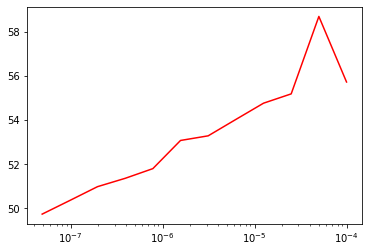

In [26]:
rr = lr[::-1]
plt.xscale('log')
plt.plot(lr,benches, color = 'red')

print(lr)
#print(rr)
print(benches)

0.001


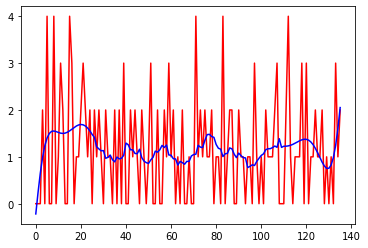

In [41]:
#print(scores)
print(game.learningrate)

printscores = []
for item in scores:
    printscores.append(float(item[0]))

printscores_filtered = savgol_filter(printscores, 51, 9)    
plt.plot(printscores, color = 'red')
plt.plot(printscores_filtered, color = 'blue')

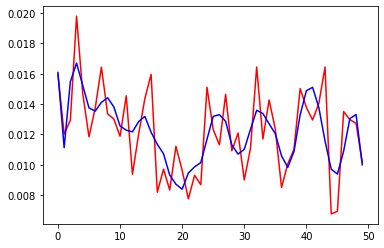

In [44]:
printscores = []
for item in overallscores:
    printscores.append(float(item[0])/float(item[1]))

    
printscores_filtered = savgol_filter(printscores, 21, 9)    
plt.plot(printscores, color = 'red')
plt.plot(printscores_filtered, color = 'blue')

In [14]:
game.print_overall_score()

----> SCORE is 90
----> DELETED BATCHES is 3740
----> ACCUMULATED is [5.36582862 2.62622556 0.17611884 4.6215671 ]


(90, 3740)

In [25]:
lr = np.random.rand(10)/1000

In [26]:
print(lr)

[0.0001639  0.00060059 0.0005564  0.00078309 0.00029834 0.00062648
 0.0006324  0.00042229 0.00044816 0.00057074]


In [11]:
now = datetime.now()

print(f"{datetime.now():%Y-%m-%d_%H-%M-%S}")

2020-09-26_10-53-12


In [12]:
print(f"{0.454545454545:.5f}")

0.45455


In [45]:
print(len(game.shufflelist))
acount = 0
pcount = 0
mcount = 0
for (cs, act, rew, fs, term) in game.shufflelist:
    if rew == game.MAXREWARD:
        acount += 1
    if rew == game.MOVEPENALTY:
        mcount += 1
    if rew == game.PENALTY:
        pcount += 1
print(acount)
print(pcount)
print(mcount)


20000
242
121
19637


In [36]:
lr = np.array([np.random.uniform(0.5,1) for i in range(5)])/2000
print(lr)

[0.00045824 0.00030852 0.00048535 0.00037981 0.00044063]


In [56]:
lr = [0.002*pow(0.5,i) for i in range(1,10)]
print(lr)

[0.001, 0.0005, 0.00025, 0.000125, 6.25e-05, 3.125e-05, 1.5625e-05, 7.8125e-06, 3.90625e-06]


In [94]:
math.sqrt(30)

5.477225575051661